The workflow will involve
- [x] Reading in the csv with all the scripts and the events demarcated, generated by Paxton on the cluster
- [x] Selecting just the first script
- [x] Cleaning up the script formatting
- [x] Creating a dataframe where each row is an event segment
- [x] Identifying all the unique characters in each event segment (new column)
- [x] Saving the number of unique characters in each event segment (new column)
- [x] Getting average word embedding for each segment, calculated from each individual word (50 dimensional vector) (new column)
- [x] Getting correlation across word embeddings for all words in a segment (new colum)
- [x] Extracting average sentiment of words in each segment (new column)

### Loading relevant libraries

In [1]:
import os
import requests as req
import seaborn as sns
import hypertools as hyp
import pandas as pd
import numpy as np
import html2text
import markdown
from bs4 import BeautifulSoup
import re
from num2words import num2words
from scipy.spatial.distance import cdist, pdist, squareform
import nltk

from nltk.corpus import stopwords as sw
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
import csv
import sys
csv.field_size_limit(sys.maxsize)

131072

In [3]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

### Reading in csv containing scripts and event boundaries

In [19]:
root_dir = '/Users/vassiki/Desktop/narrative_complexity/data/'
#fn = 'first2_with_times.csv'
fn = 'finished_data.csv'
df = pd.read_csv(os.path.join(root_dir, fn))

### Select and format script by url

In [5]:
def wipe_formatting(script, rehtml=False):
    parser = html2text.HTML2Text()
    parser.wrap_links = True
    parser.skip_internal_links = True
    parser.inline_links = True
    parser.ignore_anchors = True
    parser.ignore_images = True
    parser.ignore_emphasis = True
    parser.ignore_links = True
    text = parser.handle(script)
    text = text.strip(' \t\n\r')
    if rehtml:
        text = text.replace('\n', '<br/>')
        text = text.replace('\\', '')
    md = markdown.markdown(text)
    soup=BeautifulSoup(md,'html5lib')
    soup=soup.get_text()
    soup = soup.replace('\n', ' ')
    return soup

In [6]:
def load_data(filepath, fileid):
    data_dir = os.path.dirname(filepath)
    
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    if not os.path.exists(filepath):
        print('downloading data...')
        dl(fileid, filepath)
        
    print('loading data...')
    data = pd.read_csv(filepath)
    return data.dropna(subset=['script'])

In [7]:
def cleanup_text(transcript):
    #lower_nopunc = re.sub("[^\w\s.]+", '', transcript.lower())    # remove all punctuation except periods (delimiters)
    lower_nopunc = re.sub("[^\w\s.]+", '', transcript)
    no_digit = re.sub(r"(\d+)", lambda x: num2words(int(x.group(0))), lower_nopunc)    # convert digits to words
    spaced = ' '.join(no_digit.replace(',', ' ').split())    # deal with inconsistent whitespace
    return spaced

In [8]:
def get_windows(transcript, wsize=50):
    cleaned = cleanup_text(wipe_formatting(transcript))
    text_list = cleaned.split('.')
    video_w = []
    
    for ix, sentence in enumerate(text_list):
        video_w.append(' '.join(text_list[ix:ix+wsize]))
        
    return video_w

In [9]:
def get_event_segments(df, row_index):
    #vals = df[df.index == row_index]['event onsets/offsets'][row_index]
    nums = df[df.index == row_index]['event_boundaries'][row_index]
    #nums = eval(vals)
    return [(nums[x][0], nums[x][1]+1) for x in range(len(nums))]

New script extractor

In [10]:
def resample_event_boundaries(ebounds, total_window_length):
    orig_max = total_window_length
    new_max = 1000
    new_event_bounds = []
    for idx, eb in enumerate(ebounds):    
        event_length = eb[1] - eb[0]
        new_event_length_ = (event_length * orig_max)/new_max
        new_event_length = int(np.floor(new_event_length_))
        if idx == 0:
            first_index = 0
            next_index = int(np.floor(new_event_length))
            new_event_bounds.append((first_index, next_index))
        else:
            first_index = new_event_bounds[idx-1][1]
            first_index += 1
            next_index = first_index + new_event_length
            new_event_bounds.append((first_index, next_index))
            if next_index > orig_max:
                new_event_bounds.append((first_index, orig_max))
                break
    return new_event_bounds
            

In [11]:
def extract_script_info(title, script_df, events_df):
    #row_index = df[df.url == url].index[0]
    
    if script_df[script_df['title'].str.contains(title)].size == 0:
        raise Exception('script text is not available')
    else:
        script_row_index = script_df[script_df.title == title].index[0]
    
    events_row_index = events_df[events_df.title == title].index[0]
    print('title is {0} eventdf index is {1} and script index is {2}'.format(title, events_row_index, script_row_index))
    # get some useful info using the index
    #title = df.loc[row_index, 'title']
    #genres = df.loc[row_index, 'genres']
    
    
    events = events_df.loc[events_row_index, 'n_events']
    script = script_df.loc[script_row_index, 'script']
    
    script_windows = get_windows(script, wsize=50)    
    # getting most important components
    orig_event_identifiers = get_event_segments(events_df, events_row_index)
    event_identifiers = resample_event_boundaries(orig_event_identifiers, len(script_windows))
 
    new_script_df = pd.DataFrame()
    
    event_words = []
    num_sentences = []
    for idx, event in enumerate(event_identifiers):
        event_content = script_windows[event[0]:event[1]]
        event_words.append([event_content])
        num_sentences.append(len(event_content))
    
    new_script_df = pd.DataFrame(event_words, columns={'content'})
    #events_df['title'] = title
    new_script_df['title'] = title
    new_script_df['intervals'] = event_identifiers
    #events_df['genre'] = genres
    new_script_df['num_events'] = events
    new_script_df['num_sentences'] = num_sentences
    
    #return events_df
    return new_script_df

In [12]:
# let's get the events dataframe for the first script
url = 'http://www.imsdb.com/scripts/10-Things-I-Hate-About-You.html'
#url = 'http://www.imsdb.com/scripts/12-and-Holding.html'
events_df = extract_script_info(url, df)

NameError: name 'df' is not defined

### Annotating characters in each row

In [12]:
def tag_entities(word_window):
    characters = []
    doc = nlp(word_window)
    annotations = [(X.text, X.label_) for X in doc.ents]
    return annotations

In [13]:
def extract_characters(annotations):    
    return [ann[0] for ann in annotations if ann[1] == 'PERSON']

In [14]:
def characters_over_script(words):
    df = pd.DataFrame()
    for idx, window in enumerate(words):
        annotations = tag_entities(window)
        characters = extract_characters(annotations)
        characters_lower = [c.lower() for c in characters]
        res = pd.DataFrame.from_records([characters_lower])
        df = pd.concat([df, res], ignore_index=False)
    return df

In [15]:
def get_unique_characters(character_df):
    characters = []
    for col in list(character_df.columns):

        col_characters = list(character_df[col].unique())
        ch = [x for x in col_characters if str(x) != 'nan']
        chars_ev = [' '.join(c.split()) for c in ch]
        #first_name = [c.split(' ')[0] for c in chars_ev] 
        #unique_first = list(dict.fromkeys(chars_ev))
        pos_tag_names = nltk.pos_tag(chars_ev)
        #pos_tag_names = nltk.pos_tag(first_name)
        noun_names = [n[0] for n in pos_tag_names if 'VB' not in n[1]]
        
        #characters.extend([c for c in col_characters if c not in characters])
        characters.extend([c for c in noun_names if c not in characters])
    #cleanedList = [x for x in characters if str(x) != 'nan']
    characters.sort()
    return characters

In [16]:
def remove_repetitions(char_list):
    for char in char_list:
        for char2 in char_list:
            if char != char2:
                first_char_len = len(char)
                second_char_len = len(char2)
                if first_char_len >= second_char_len:
                    string = char
                    pattern = char2
                else:
                    string = char2
                    pattern = char
                if string in char_list and pattern in string:
                    char_list.remove(string)
    return char_list

In [17]:
def count_character_occurence(character_df):
    #characters = get_unique_characters(character_df)
    c = get_unique_characters(character_df)
    characters = remove_repetitions(c)
    flip_df = character_df.transpose()
    flip_df.columns = np.arange(flip_df.shape[1])
    char_dict = {}
    for char in characters:
        char_counts_per_col = np.zeros(flip_df.shape[1])
        for idx in list(flip_df.columns):
            col_count = flip_df[idx].str.contains(char).sum()
            char_counts_per_col[idx] = col_count
        char_dict[char] = char_counts_per_col
    return char_dict    

In [18]:
def get_character_counts_per_event(edf):
    
    edf['characters'] = ''
    for event_id in range(edf.shape[0]):
        event_char_df = characters_over_script(edf.loc[event_id, 'content'])
        event_char_count = count_character_occurence(event_char_df)
        event_char_count_sum = {c:event_char_count[c].sum() for c in event_char_count}
        num_chars = len(event_char_count_sum.keys())
        edf.loc[event_id, 'num_characters'] = num_chars
        edf.loc[event_id, 'characters'] = [event_char_count_sum]
    return edf        

In [22]:
# this will take around 5 minutes to run
events_char_df = get_character_counts_per_event(events_df)

In [19]:
def plot_one_event(row):
    index = row.index[0]
    print(index)
    char_df = characters_over_script(row.loc[index, 'content'])
    cd = count_character_occurence(char_df)
    cd_df = pd.DataFrame(cd)
    cd_df = cd_df.rename(index={i: "Window {0}".format(i) for i in cd_df.index})
    ax = plt.axes()
    sns.heatmap(cd_df)
    plt.savefig('event_{}.png'.format(index), bbox_inches = "tight")

In [20]:
def plot_all_events(events_char_df, threshold = 3):
    d = pd.DataFrame()

    for row_idx in range(events_char_df.shape[0]):
        row_chars = list(events_char_df.loc[row_idx, 'characters'].keys())
        res = pd.DataFrame.from_records([row_chars])
        d = pd.concat([d, res], ignore_index=False)
    cd = count_character_occurence(d)
    cd_df = pd.DataFrame(cd)
    cd_df = cd_df.rename(index={i: "Event {0}".format(i) for i in cd_df.index})
    above_thresh = cd_df[cd_df.columns[(cd_df>threshold).any()]]
    plt.subplots(figsize=(20,15))
    ax = plt.axes()
    sns.heatmap(above_thresh, xticklabels=list(above_thresh.columns), yticklabels=list(above_thresh.index))
    ax.set_title('Characters appearing more than {0} times within an event, Total {1}'.format(threshold,above_thresh.shape[1]))
    plt.savefig('character_mentions_{0}.png'.format(threshold), bbox_inches = "tight")

In [21]:
def plot_recurrent_characters(events_char_df, threshold = 20):
    d = pd.DataFrame()

    for row_idx in range(events_char_df.shape[0]):
        row_chars = list(events_char_df.loc[row_idx, 'characters'].keys())
        res = pd.DataFrame.from_records([row_chars])
        d = pd.concat([d, res], ignore_index=False)
    cd = count_character_occurence(d)
    cd_df = pd.DataFrame(cd)
    cd_df = cd_df.rename(index={i: "Event {0}".format(i) for i in cd_df.index})
    above_thresh = cd_df[cd_df.columns[cd_df.sum()>threshold]]
    print(above_thresh.shape)
    plt.subplots(figsize=(20,15))
    ax = plt.axes()        
    sns.heatmap(above_thresh, xticklabels=list(above_thresh.columns), yticklabels=list(above_thresh.index))
    ax.set_title('Characters appearing in more than {0} events, Total {1}'.format(threshold,above_thresh.shape[1]))
    plt.savefig('character_recurrence_{0}.png'.format(threshold), bbox_inches = "tight")

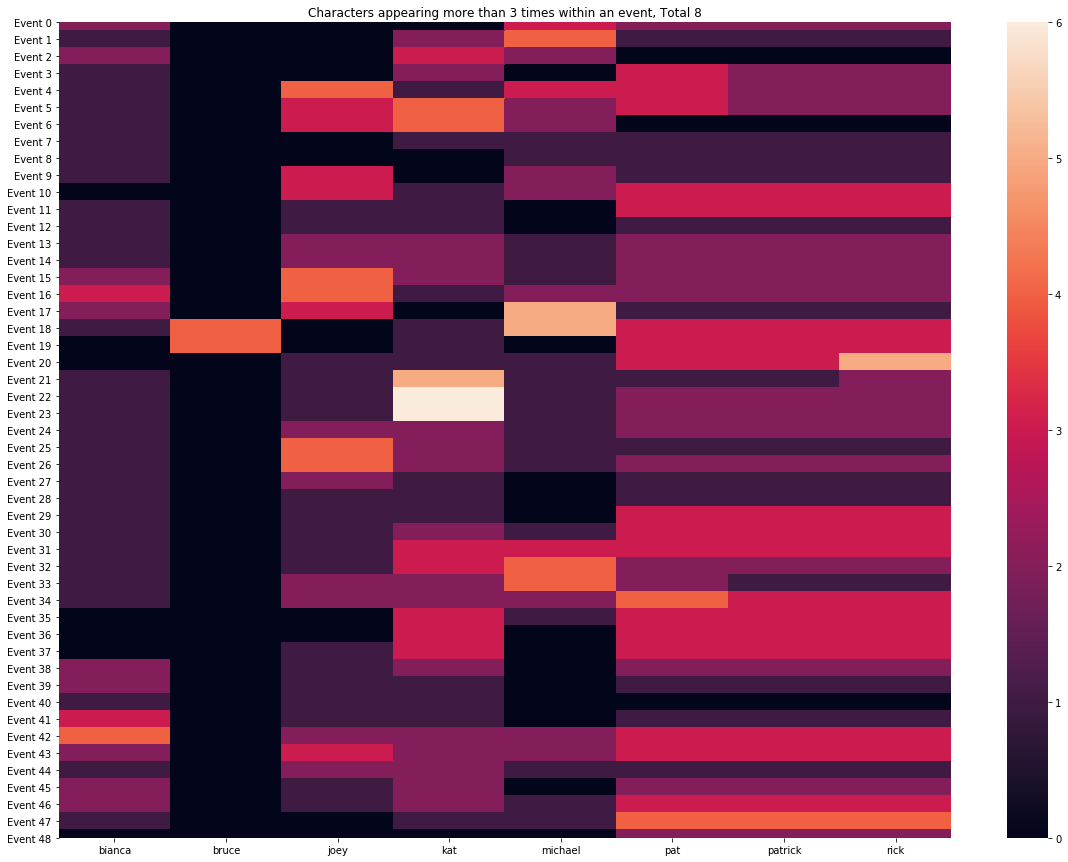

In [26]:
plot_all_events(events_char_df, 3)

(49, 16)


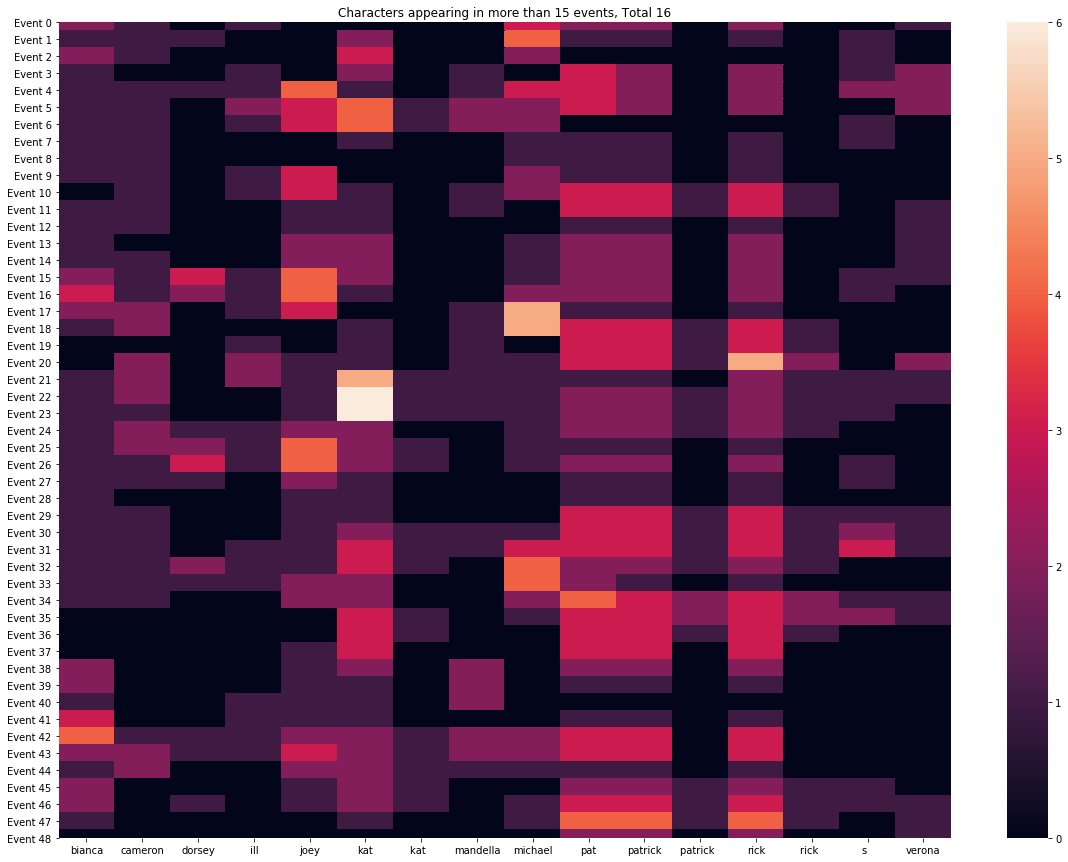

In [29]:
plot_recurrent_characters(events_char_df, threshold = 15)

### Word embeddings for events

In [26]:
glove_embeddings = '/Users/vassiki/Downloads/glove.6B/glove.6B.50d.txt'

In [19]:
def load_embeddings(embedding_file):
    emb = {}
    with open(embedding_file, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for row in spamreader:
            emb[''.join(row[0])] = ' '.join(row[1:])
    return emb

In [28]:
# this might take a couple of minutes!
embedding = load_embeddings(glove_embeddings)

In [20]:
def embedding_extractor(tokens, embedding):
    weights = []
    for tok in tokens:
        if tok in embedding.keys():
            weights.append(np.array([float(val) for val in embedding[tok].split(' ')]))
    return np.array(weights)

In [21]:
def get_semantic_weights(edf):
    for i in range(edf.shape[0]):
        content = edf.loc[i,'content']
        flat_content= ' '.join(content)
        stop = sw.words('english')
        tokens = nltk.word_tokenize(flat_content)
        cleaned_tokens = [t.lower() for t in tokens if len(t) > 2 and t not in stop]
        tok_emb_arr = embedding_extractor(cleaned_tokens, embedding)
        mean_emb_val = np.mean(np.mean(tok_emb_arr, axis=0))
        corr = np.corrcoef(tok_emb_arr)
        mean_corr = np.mean(corr, axis=0)
        mean_corr_ev = np.round(np.mean(mean_corr),3)    
        
        edf.loc[i, 'mean_emb'] = mean_emb_val
        edf.loc[i, 'mean_emb_vec'] = str(np.mean(tok_emb_arr, axis=0))
        edf.loc[i, 'corr_across_tokens'] = mean_corr_ev

    return edf

In [31]:
e = get_semantic_weights(events_char_df)

In [32]:
e.to_csv('annotations.csv', index=None)

### Extracting sentiments for each event

In [28]:
#sentences
def prepare_sentence_tokens(edf, row_index):
    content = [ev.split('  ') for ev in edf.loc[row_index,'content']]
    flat_content = sum(content, [])
    content_str = '. '.join(flat_content)
    tokens = nltk.sent_tokenize(content_str)
    return tokens

In [29]:
def sentiment_extractor(tokens):
    df = pd.DataFrame()
    for w in tokens:
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(w)
        res = pd.DataFrame.from_records([ss])
        res['word'] = w
        df = pd.concat([df, res], ignore_index=False)
    return df

In [30]:
def sentiment_per_event(edf):
    for row in range(edf.shape[0]):
        tokens = prepare_sentence_tokens(edf, row)
        sentiments = sentiment_extractor(tokens)
        
        edf.loc[row, 'sent_positive'] = sentiments['pos'].mean()
        #edf.loc[row, 'sent_positive'] = sentiments['pos'].count()
        edf.loc[row, 'sent_negative'] = sentiments['neg'].mean()
        edf.loc[row, 'sent_neutral'] = sentiments['neu'].mean()
        edf.loc[row, 'compound'] = sentiments['compound'].mean()
    return edf

In [31]:
sec_df = sentiment_per_event(e)

KeyboardInterrupt: 

In [ ]:
sec_df.to_csv('annotations_with_sentiment.csv')

### Looping through more movies

In [22]:
script_df = pd.read_csv('/Users/vassiki/Desktop/narrative_complexity/data/scriptdata_final.csv')

In [23]:
def get_movie_df(root_dir, title, df, script_df, embedding_df):
    
    movie_data_path = os.path.join(root_dir, 'movie_data')
    if not os.path.exists(movie_data_path):
        os.mkdir(movie_data_path)
    title_str = '_'.join(title.lower().split(' '))
    
    print('Getting data for {}...'.format(title))
    # words will actually have to be read from mark's original script
    #events_df = extract_script_info(title, script_df)
    events_df = extract_script_info(title, script_df, df)
    print('Performing named entity recognition...')
    events_char_df = get_character_counts_per_event(events_df)
    #print('Extracting word embeddings...')
    #e = get_semantic_weights(events_char_df)
    print('Saving the file...')
    save_fn = '{}.csv'.format(os.path.join(movie_data_path, title_str))
    events_char_df.to_csv(save_fn, index=None)
    
    return events_char_df


In [34]:
one_t = df.loc[0, 'title']
#d = extract_script_info(one_t, df, script_df)
#get_movie_df(root_dir, title, df, script_df, embedding_df):
d = get_movie_df(root_dir, one_t, df, script_df,embedding)

Getting data for Peggy Sue Got Married...
title is Peggy Sue Got Married eventdf index is 0 and script index is 781
Performing named entity recognition...
Saving the file...


In [24]:
root_dir = '/Users/vassiki/Desktop/narrative_complexity/data/'
#fn = 'finished_data.csv'
#df = pd.read_csv(os.path.join(root_dir, fn))
fn = 'finished_data.p'
df = pd.read_pickle(os.path.join(root_dir, fn))

In [25]:
glove_embeddings = '/Users/vassiki/Downloads/glove.6B/glove.6B.50d.txt'
embedding = load_embeddings(glove_embeddings)

Vassiki's chosen movies

In [26]:
titles = ['2001: A Space Odyssey', '10 Things I Hate About You', 'Black Swan', 'Lord of the Rings: Fellowship of the Ring, The', \
          'Scott Pilgrim vs the World', 'Avatar', 'Forrest Gump', 'Star Wars: The Phantom Menace', 'Citizen Kane', 'V for Vendetta']

In [27]:
subdf = pd.DataFrame()
for t in titles:
    row = df[df.title.str.contains(t)]
    subdf = pd.concat([subdf, row], ignore_index=False)

In [28]:
for movie_num in subdf.index:
    title = subdf.loc[movie_num, 'title']
    d = get_movie_df(root_dir, title, subdf, script_df,embedding)
    #e = get_movie_df(root_dir, title, df, embedding)

Getting data for 2001: A Space Odyssey...
title is 2001: A Space Odyssey eventdf index is 35 and script index is 10
Performing named entity recognition...
Saving the file...
Getting data for 10 Things I Hate About You...
title is 10 Things I Hate About You eventdf index is 782 and script index is 0
Performing named entity recognition...
Saving the file...
Getting data for Black Swan...
title is Black Swan eventdf index is 90 and script index is 161
Performing named entity recognition...
Saving the file...
Getting data for Lord of the Rings: Fellowship of the Ring, The...
title is Lord of the Rings: Fellowship of the Ring, The eventdf index is 245 and script index is 639
Performing named entity recognition...
Saving the file...
Getting data for Scott Pilgrim vs the World...
title is Scott Pilgrim vs the World eventdf index is 572 and script index is 882
Performing named entity recognition...
Saving the file...
Getting data for Avatar...
title is Avatar eventdf index is 814 and script in

Movies with maximum number of events

In [46]:
s_df = df.sort_values('n_events')
subdf = s_df.tail(10)

In [45]:
for movie_num in subdf.index:
    title = subdf.loc[movie_num, 'title']
    d = get_movie_df(root_dir, title, subdf, script_df,embedding)
    #e = get_movie_df(root_dir, title, df, embedding)

Getting data for Insomnia...
title is Insomnia eventdf index is 50 and script index is 543
Performing named entity recognition...
Saving the file...
Getting data for S. Darko...
title is S. Darko eventdf index is 77 and script index is 871
Performing named entity recognition...
Saving the file...
Getting data for Bourne Identity, The...
title is Bourne Identity, The eventdf index is 787 and script index is 188
Performing named entity recognition...
Saving the file...
Getting data for American Werewolf in London...
title is American Werewolf in London eventdf index is 340 and script index is 68
Performing named entity recognition...
Saving the file...
Getting data for Grudge, The...
title is Grudge, The eventdf index is 654 and script index is 463
Performing named entity recognition...
Saving the file...
Getting data for Invention of Lying, The...
title is Invention of Lying, The eventdf index is 883 and script index is 550
Performing named entity recognition...
Saving the file...
Getti

Getting back window lengths


In [108]:
def resample_event_boundaries(ebounds, total_window_length):
    orig_max = total_window_length
    new_max = 1000
    new_event_bounds = []
    for idx, eb in enumerate(ebounds):    
        event_length = eb[1] - eb[0]
        new_event_length_ = (event_length * orig_max)/new_max
        new_event_length = int(np.floor(new_event_length_))
        if idx == 0:
            first_index = 0
            next_index = int(np.floor(new_event_length))
            new_event_bounds.append((first_index, next_index))
        else:
            first_index = new_event_bounds[idx-1][1]
            first_index += 1
            next_index = first_index + new_event_length
            new_event_bounds.append((first_index, next_index))
            if next_index > orig_max:
                new_event_bounds.append((first_index, orig_max))
                break
    return new_event_bounds
            

In [106]:
neb = resample_event_boundaries(boundaries)

In [112]:
len(script_windows)

1762